In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import numpy as np
import os
import io
import warnings
import keras
import regex as re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D,Dropout,MaxPooling1D,Flatten
from unidecode import unidecode
#import en_core_web_md
#nlp = en_core_web_md.load()
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix

Load dataset.

In [3]:
df = pd.read_parquet("train-00000-of-00001.parquet")

In [4]:
df.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [7]:
df.shape

(416809, 2)

In [9]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [13]:
df.label.value_counts() / len(df)

label
1    0.338445
0    0.290749
3    0.137514
4    0.114470
2    0.082901
5    0.035921
Name: count, dtype: float64

Pre-processing

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stops = set(stopwords.words('english'))
import spacy
sp = spacy.load('en_core_web_sm')

spacy_stopwords = sp.Defaults.stop_words

stops = stops.union(spacy_stopwords)

stops = stops.union({' ','.',',','',"i'm",'u','rt','http','like','//t','girl','girls',"'",'"','mkr'})

def remove_stop_words(words):

   return [word.lower() for word in words if word.lower() not in stops]  

import textcleaner as tc


def clean_text(text): 
    
  token_text = nlp(text)
    
  text = [element.lemma_.lower() for element in token_text]  

  clean_text = remove_stop_words(text)  
    
  text = " ".join(clean_text).strip().lower()  
  
  text = re.sub(r'[0-9]+','',text).strip()
  text = re.sub(r'[@]+','@',text).strip()
  text = re.sub(r'@','@ ', text).strip()  
  text = re.sub(r'[#]+','#',text).strip()
  text = re.sub(r'#','# ', text).strip() 
#  text = re.sub(r'\x[0-9]+','',text).strip()  
  text = re.sub(r'rt[\s]+','', text).strip()
  text = re.sub(r"[,.\"!$%^&*(){}?/;`~:<>_+=-]", "", text).strip()
  text = re.sub(r'http[A-Za-z0-9]+','', text).strip()
  text = re.sub(r'bbc','',text) .strip() 
  emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text).strip()   
  text = re.sub(r"i'm", "i am", text).strip()
  text = re.sub(r"he's", "he is", text).strip()
  text = re.sub(r"she's", "she is", text).strip()
  text = re.sub(r"that's", "that is", text).strip()        
  text = re.sub(r"what's", "what is", text).strip()
  text = re.sub(r"where's", "where is", text).strip() 
  text = re.sub(r"\'ll", " will", text).strip()  
  text = re.sub(r"\'ve", " have", text).strip()  
  text = re.sub(r"\'re", " are", text).strip()
  text = re.sub(r"\'d", " would", text).strip()
  text = re.sub(r"\'ve", " have", text).strip()
  text = re.sub(r"won't", "will not", text).strip()
  text = re.sub(r"don't", "do not", text).strip()
  text = re.sub(r"did't", "did not", text).strip()
  text = re.sub(r"can't", "can not", text).strip()
  text = re.sub(r"it's", "it is", text).strip()
  text = re.sub(r"couldn't", "could not", text).strip()
  text = re.sub(r"have't", "have not", text).strip()
  text = re.sub(r'[\s]+',' ',text)
    
  text = text.lower()   
    
#  text = remove_stop_words2(text).strip()

#  text = " ".join(text).strip()
 
  return text.split(" ")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


In [8]:
df['token_text'] = df['text'].apply(clean_text)

df['text_cleaned'] = df['token_text'].apply(lambda x : " ".join(x))
df.head()

,text,label,token_text,text_cleaned
0,i feel awful about it too because it s my job ...,0,"[feel, awful, job, position, succeed, happen]",feel awful job position succeed happen
1,im alone i feel awful,0,"[feel, awful]",feel awful
2,ive probably mentioned this before but i reall...,1,"[probably, mention, feel, proud, actually, new...",probably mention feel proud actually new year ...
3,i was feeling a little low few days back,0,"[feel, little, low, day]",feel little low day
4,i beleive that i am much more sensitive to oth...,2,"[beleive, sensitive, people, feeling, tend, co...",beleive sensitive people feeling tend compassi...


In [18]:
df.to_csv("df_clean.csv")

In [15]:
df = pd.read_csv("df_clean.csv",index_col = 0)

In [16]:
df.head()

,text,label,token_text,text_cleaned
0,i feel awful about it too because it s my job ...,0,"['feel', 'awful', 'job', 'position', 'succeed'...",feel awful job position succeed happen
1,im alone i feel awful,0,"['feel', 'awful']",feel awful
2,ive probably mentioned this before but i reall...,1,"['probably', 'mention', 'feel', 'proud', 'actu...",probably mention feel proud actually new year ...
3,i was feeling a little low few days back,0,"['feel', 'little', 'low', 'day']",feel little low day
4,i beleive that i am much more sensitive to oth...,2,"['beleive', 'sensitive', 'people', 'feeling', ...",beleive sensitive people feeling tend compassi...


From texts to sequences.

In [26]:
df["text_cleaned"] = df.text_cleaned.astype(str)

In [28]:
import numpy as np
tokenizer1 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer1.fit_on_texts(df.text_cleaned)
df["text_encoded"] = tokenizer1.texts_to_sequences(df.text_cleaned)
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))

In [30]:
df1 = df[df["len_text"]!=0]

text_pad1 = tf.keras.preprocessing.sequence.pad_sequences(df1.text_encoded, padding="post")

y = df1['label'].values

Split between train, test and validation datasets. 

In [31]:
X_train,X_testi,y_train,y_testi = train_test_split(text_pad1,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

Transforme y_train into a matrix with 0 and 1 depending of the class. 

In [32]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=6)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=6)

In [34]:
X_train.shape

(249894, 31)

Design of the neural network. 

In [38]:
vocab_size = tokenizer1.num_words
model1 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],\
                                         name="embedding"),
                  Conv1D(
filters = 14, # the number of neurons on the convolutional layer
kernel_size = (3), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "same", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = 'l2' # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
#                  keras.layers.Dense(50, activation='relu'),
                  keras.layers.Dropout(0.2),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  keras.layers.Dropout(0.4),
#                  tf.keras.layers.Dense(3, activation='relu'),
#                  keras.layers.Dropout(0.2),
                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(6, activation="softmax"),
])

In [40]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 31, 128)             │         128,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 31, 14)              │           5,390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 14)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,860 (522.89 KB)

 Trainable params: 133,860 (522.89 KB)

 Non-trainable params: 0 (0.00 B)

Fitting the neural network

In [42]:
optimizer= keras.optimizers.Adam()

model1.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model1.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=25, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 1.9161 - mean_absolute_error: 0.2706 - val_loss: 1.7030 - val_mean_absolute_error: 0.2643
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 1.7053 - mean_absolute_error: 0.2615 - val_loss: 1.6272 - val_mean_absolute_error: 0.2599
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 1.6328 - mean_absolute_error: 0.2581 - val_loss: 1.5923 - val_mean_absolute_error: 0.2556
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 1.6363 - mean_absolute_error: 0.2589 - val_loss: 1.5901 - val_mean_absolute_error: 0.2580
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 1.5953 - mean_absolute_error: 0.2560 - val_loss: 1.5730 - val_mean_absolute_error: 0.2551
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 1.5885 - mean_absolute_error: 0.2557 - val_loss: 1.5576 - val_mean_absolute_error: 0.2538
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 1.5839 - mean_absolute_error: 0.2552 - val_lo

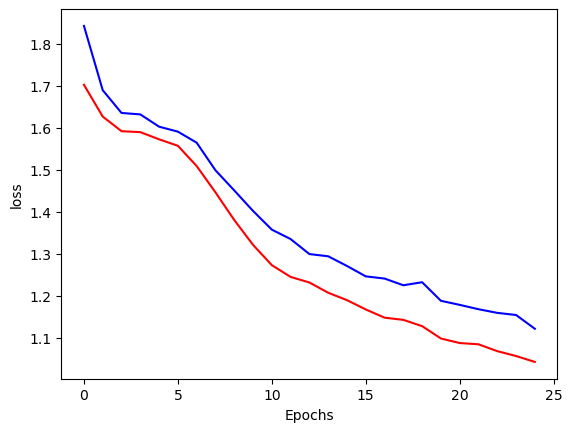

In [43]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

Evaluating the performance

In [44]:
y_train_pred_prob = model1.predict(X_train)
y_test_pred_prob = model1.predict(X_test)

7810/7810 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


In [45]:
y_train_pred = y_train_pred_prob.argmax(axis = 1)
y_test_pred = y_test_pred_prob.argmax(axis = 1)

In [56]:
base_case_train = np.ones(y_train_pred.shape)
base_case_test = np.ones(y_test_pred.shape)

In [58]:
np.mean(y_train_pred == y_train.argmax(axis = 1))

0.6423243455225015

In [70]:
np.mean(y_train.argmax(axis = 1) == base_case_train)

0.3385555475521621

In [62]:
np.mean(y_test_pred == y_test)

0.6418881605800859

In [74]:
np.mean(y_test == base_case_test)

0.3385555475521621

In [76]:
np.mean(np.abs(y_train_pred - y_train.argmax(axis = 1))<=1)

0.8589201821572346

In [78]:
np.mean(np.abs(base_case_train - y_train.argmax(axis = 1))<=1)

0.7123900533826343

In [80]:
np.mean(np.abs(y_test_pred - y_test)<=1)

0.8567912795025091

In [84]:
np.mean(np.abs(base_case_test - y_test)<=1)

0.7123940550793536

In [86]:
pd.DataFrame({"difference":np.abs(y_train_pred - y_train.argmax(axis = 1))}).value_counts() / len(y_train_pred)

difference
0             0.642324
1             0.216596
2             0.074316
3             0.034114
4             0.020349
5             0.012301
Name: count, dtype: float64

In [90]:
pd.DataFrame({"difference":np.abs(base_case_train - y_train.argmax(axis = 1))}).value_counts() / len(y_train_pred)

difference
1.0           0.373835
0.0           0.338556
2.0           0.137270
3.0           0.114401
4.0           0.035939
Name: count, dtype: float64

In [94]:
pd.DataFrame({"difference":np.abs(base_case_test - y_test)}).value_counts() / len(y_test_pred)

difference
1.0           0.373839
0.0           0.338556
2.0           0.137266
3.0           0.114397
4.0           0.035943
Name: count, dtype: float64